# Testing variant callers on simulated data

The goal of this part of the study is to test the ability of several variant callers to identify minority variants in simulated data. Variants were placed at varying allele frequencies and data was downsampled to simulate different coverage depths. The variants exist both at set allele frequencies (ie. 1%, 2%, 4% etc) and at random allele frequencies.   

The variant callers tested in this study are:
- freebayes  
- haplotype caller from GATK (abbreviated hc)   
- ivar  
- lofreq  
- mutect2 (including several different options for analysis)  
- timo: an in-house variant caller created by the Ghedin lab  
- varscan  

The allele frequencies tested were: 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.25, 0.5 and random  
The coverages tested were: 1, 10, 100, 200, 300, 500, 1000, 10000, and 100000  


#### Written by: Allison Roder

In [29]:
#load packages
library(ggplot2)
library(plyr)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(glue)
library(cowplot)
library(UpSetR)
library(pheatmap)
library(vcfR)
library(igraph)
library(ggpubr)

In [30]:
# set folder locations 
# input files should be in mva folder

#project_folder <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/projects/COV2-SNV'
#mva_folder <- glue("{project_folder}/simulation/20220512")
project_folder = '../data'

In [31]:
tool_colors <- c('#CC2F42', # freebayes - red
                 '#35B6E9', # hc - bright blue
                 '#009E73', # ivar - green
                 '#F9BECD', # lofreq - pink
                 '#F0E442', # mutect2 - yellow
                 '#CCD2EB', # timo - light purple
                 '#9B9E9A', # varscan - grey
                 '#555555') # varscan, custom1 - darker grey
cat_colors <- c('#2F142B', # TP - dark purple
                '#F2A07B', # FP - peach
                '#43668B') # FN - blue
cov_af_colors <- c('#DDDDDD', # 100X - lightest grey
                '#BBBBBB', # 200X
                '#999999', # 300X
                '#777777', # 500X
                '#555555', # 1000X
                '#333333', # 10000X
                '#111111') # 100000X - darkest grey
virus_colors <- c('#2F142B', # H1N1 - dark purple
                  '#F2A07B', # H3N2 - peach
                  '#43668B', # VICT - blue
                  '#8DA1E2') # SARS - light purple

In [32]:
#setwd(mva_folder)
setwd(project_folder)

In [33]:
# load in simulated data
sarsVV <- read.csv(file="SARS-CoV2-3_kickass_mcclintock_af_data.csv",header = T,sep=',')
h1n1VV <- read.csv(file="H1N1-7_agitated_thompson_af_data.csv",header = T,sep=',')
h3n2VV <- read.csv(file="H3N2-4_thirsty_volta_af_data.csv",header = T,sep=',')
vicVV <- read.csv(file="Vic-3_fervent_raman_af_data.csv",header = T,sep=',')

In [34]:
# combine them into a single dataframe
VV <- do.call("rbind", list(sarsVV, h1n1VV, h3n2VV, vicVV))

In [35]:
# format columns for analysis
VV$sample_id = as.character(VV$sample_id)
VV$dp = as.numeric(VV$dp)

In [36]:
# separate the sample_id info into separate columns for each data point
VV = separate(VV, sample_id, sep = "_", 
               into = c("virus","rep","AF","allele_freq","frac","seq_depth","aligner","tool","parameter","option")) %>%
  select(-c(AF, frac)) %>% droplevels()
VV$seq_depth = as.numeric(VV$seq_depth)
# coverage is a downsampled number from 100000, multiply by 100000 to get approx. coverage
VV$coverage = (VV$seq_depth * 100000)
# for tools that have parameters, combine this with the tool name
VV$tool <- paste0(VV$tool,"_",VV$parameter,"-",VV$option)
VV$option = NULL

Warning message:
“Expected 10 pieces. Missing pieces filled with `NA` in 1607681 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [37]:
# this data only uses single replicate
# filter for m1
VV <- VV %>% filter(rep == 'm1')

In [38]:
# filter out any indels, these were not analyzed in this study
VV <- VV %>% filter(ref %in% c('A','C','G','T') & alt %in% c('A','C','G','T'))

## Categorizing of variant calls

Variants exist in the data both at set allele frequencies and random allele frequencies, across a range of coverages. 

Here, we separate these two data sets and compare the variant calls to the expected variant calls.  
Based on this, we can categorize the variant calls into:  
- True positives: The variant caller accurately identifies a variant that was placed in the data. 
- False positives: The variant caller identifies a variant that doesn't exist in the data, or exists as a false variant incorporated into the error model. 
- False negatives: The variant caller missed a true variant in the data. 

In [39]:
# count total number of snps in each data set
locate_input_snps = VV %>% filter(af_golden > 0) %>%
                        select(virus, pos, ref, alt, chrom, rep) %>% unique()

In [40]:
locate_input_snps %>% group_by(virus, rep) %>% tally()

virus,rep,n
<chr>,<chr>,<int>
H1N1-7,m1,121
H3N2-4,m1,110
SARS-CoV2-3,m1,144
Vic-3,m1,118


In [41]:
# separate the set allele frequency data from the random allele frequency data
VV_setAF = filter(VV, !allele_freq == "random") %>% droplevels()
VV_randomAF = filter(VV, allele_freq == "random") %>% droplevels()

In [42]:
# add a column to label false positive, false negative and true positive to both set and random data
VV_setAF$cat <- ifelse(VV_setAF$af_golden == 0 & !VV_setAF$af_workflow == 0, 'FP',
                         ifelse(VV_setAF$af_workflow == 0 & !VV_setAF$af_golden == 0, 'FN',
                                ifelse((VV_setAF$af_golden != 0 & VV_setAF$af_workflow != 0),'TP','other')))

VV_randomAF$cat <- ifelse(VV_randomAF$af_golden == 0, 'FP',
                         ifelse(VV_randomAF$af_workflow == 0, 'FN',
                                ifelse((VV_randomAF$af_golden != 0 & VV_randomAF$af_workflow != 0),'TP','other')))

In [43]:
# separate the data frames
VV_FP <- VV_setAF %>% filter(cat == 'FP') 
VV_TP <- VV_setAF %>% filter(cat == 'TP')
VV_FN <- VV_setAF %>% filter(cat == 'FN')

# count up the number of each FP, TP and FN for each tool at each coverage and allele frequency
rFP <- VV_FP %>% group_by(virus, tool, allele_freq, coverage) %>% tally
rTP <- VV_TP %>% group_by(virus, tool, allele_freq, coverage) %>% tally
rFN <- VV_FN %>% group_by(virus, tool, allele_freq, coverage) %>% tally

names(rFP)[5] <- "FP"
names(rTP)[5] <- "TP"
names(rFN)[5] <- "FN"

# combine these into a signle data frame and fill in any instances where there are none as 0
scores_full <- merge(rFP,rTP, all.x=TRUE, all.y=TRUE)
scores_full <- merge(scores_full, rFN, all.x=TRUE, all.y=TRUE)

scores_full[is.na(scores_full)] <- 0

# calculate the following:
# conditionP = condition positive
# conditionN = condition negative
# TPR = true positive rate
# FPR = false positive rate
# FNR = false negative rate
# PPV = Precision
# recall
scores_full$conditionP <- scores_full$TP + scores_full$FN
#scores_full$conditionN <- 29903-scores_full$conditionP
scores_full$TPR <- scores_full$TP/scores_full$conditionP
#scores_full$FPR <- scores_full$FP/scores_full$conditionN
scores_full$FDR <- scores_full$FP/(scores_full$FP + scores_full$TP)
scores_full$FNR <- scores_full$FN/scores_full$conditionP
scores_full$PPV <- scores_full$TP/(scores_full$TP+scores_full$FP)
scores_full$recall <- scores_full$TP/(scores_full$TP+scores_full$FN)
scores_full[is.na(scores_full)] <- 0

In [44]:
scores_full$PPV <- as.numeric(scores_full$PPV)
scores_full$recall <- as.numeric(scores_full$recall)

scores_full <- scores_full %>% mutate(F1 = 2*((scores_full$PPV*scores_full$recall)/(scores_full$PPV+scores_full$recall)))
scores_full[is.na(scores_full)] <- 0

In [45]:
scores_full$groups <- paste0(scores_full$tool,"-",scores_full$allele_freq,"-",scores_full$coverage)

In [46]:
# multiple parameters were used for each tool
# separate into default, custom and standard
# for freebayes, the standard set of parameters is called 'custom'
default <- c('freebayes_default-NA','hc_default-NA','ivar_default-NA',
             'lofreq_default-NA','mutect2_default-unfiltered',
             'timo_default-NA','varscan_default-NA') #'mutect2_default-filtered','timo_default-no-binom-check',
custom <- c('freebayes_standard-NA','hc_custom-NA','ivar_custom-NA',
            'lofreq_custom-NA','mutect2_custom-unfiltered',
            'timo_custom-NA','varscan_custom-1-NA','varscan_custom-NA') #'mutect2_custom-filtered','timo_custom-no-binom-check',
standard <- c('freebayes_custom-NA','hc_standard-NA','ivar_standard-NA',
              'lofreq_standard-NA','mutect2_standard-unfiltered',
              'timo_standard-NA','varscan_standard-NA') #'mutect2_standard-filtered','timo_standard-no-binom-check',

In [47]:
# group them to calculate mean and std deviation across the four viruses
VV_setAF_grouped <- scores_full %>% group_by(tool, allele_freq, coverage)

In [48]:
# calculate mean and standard deviation
VV_setAF_grouped <- VV_setAF_grouped %>% summarize(mean_FDR = mean(FDR), sd_FDR = sd(FDR), 
                              mean_TPR = mean(TPR), sd_TPR = sd(TPR),
                              mean_recall = mean(recall), sd_recall = sd(recall),
                              mean_PPV = mean(PPV), sd_PPV = sd(PPV),
                              mean_F1 = mean(F1), sd_F1 = sd(F1),
                                                  n = n())

`summarise()` has grouped output by 'tool', 'allele_freq'. You can override using the `.groups` argument.


## Figure 1B: Precision/Recall

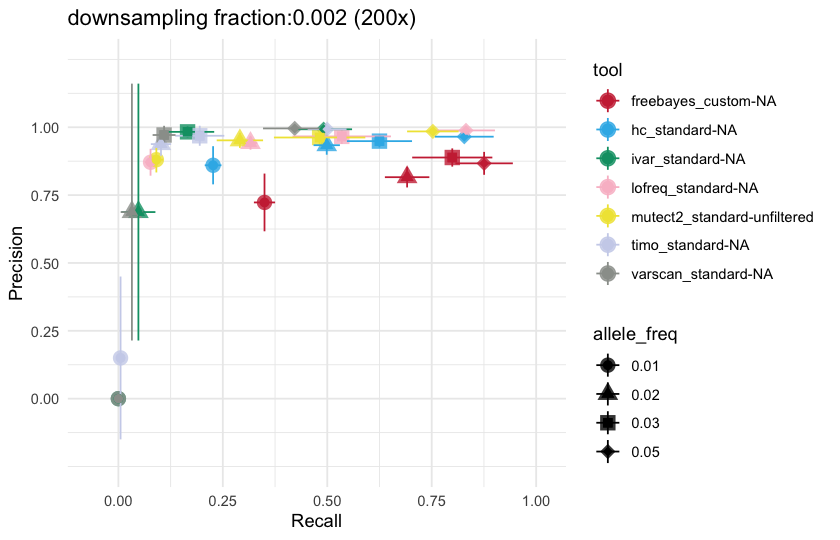

In [50]:
cov <- 200
af <- c(0.01,0.02,0.03,0.05)

plot5s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
              aes(x=mean_FDR, y=mean_TPR, shape=allele_freq, color = tool)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_TPR-sd_TPR, ymax=mean_TPR+sd_TPR)) +

    geom_pointrange(aes(xmin=mean_FDR-sd_FDR, xmax=mean_FDR+sd_FDR)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="False Discovery Rate",
                        breaks=seq(0,1,by=.25), 
                        limits=c(-0.05,1.05),expand=c(0,0)) +

    scale_y_continuous(name="True Positive Rate", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    ggtitle(glue("expected coverage:{cov}")) +

    theme_minimal()

plot6s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
             aes(x=mean_recall, y=mean_PPV, color = tool, shape=allele_freq)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_PPV-sd_PPV, ymax=mean_PPV+sd_PPV)) +

    geom_pointrange(aes(xmin=mean_recall-sd_recall, xmax=mean_recall+sd_recall)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="Recall",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.1,1.05),expand=c(0.01,0.01)) +

    scale_y_continuous(name="Precision", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.3,1.3),expand=c(0.01,0.01)) +


     scale_shape_manual(values = c(16, 17, 15, 18)) + 

    ggtitle(glue("downsampling fraction:{cov/100000} ({cov}x)")) +

    theme_minimal()

plot6s
options(repr.plot.width=7, repr.plot.height=4.5)
#ggarrange(plot6s, nrow = 1, ncol = 1)

#ggsave(plot5s, filename = glue("tpr.fpr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)
#ggsave(plot6s, filename = glue("pr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)



Warning message:
“Removed 2 rows containing missing values (`geom_segment()`).”


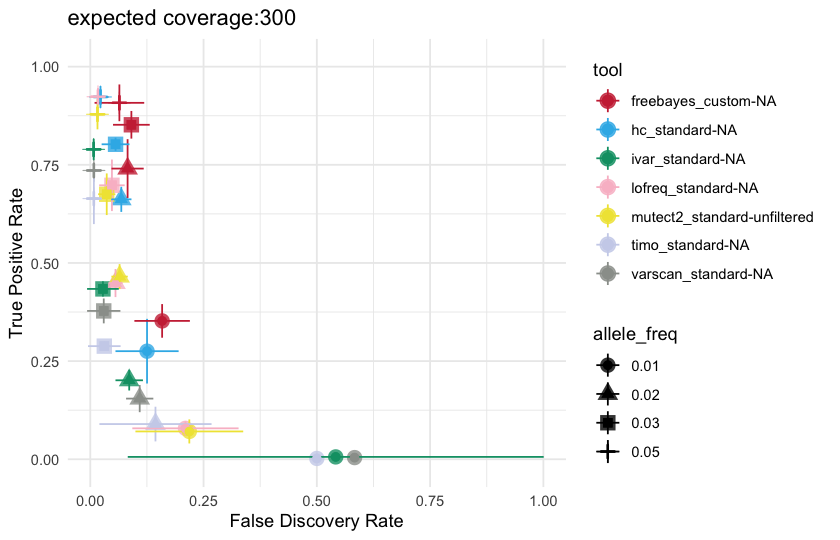

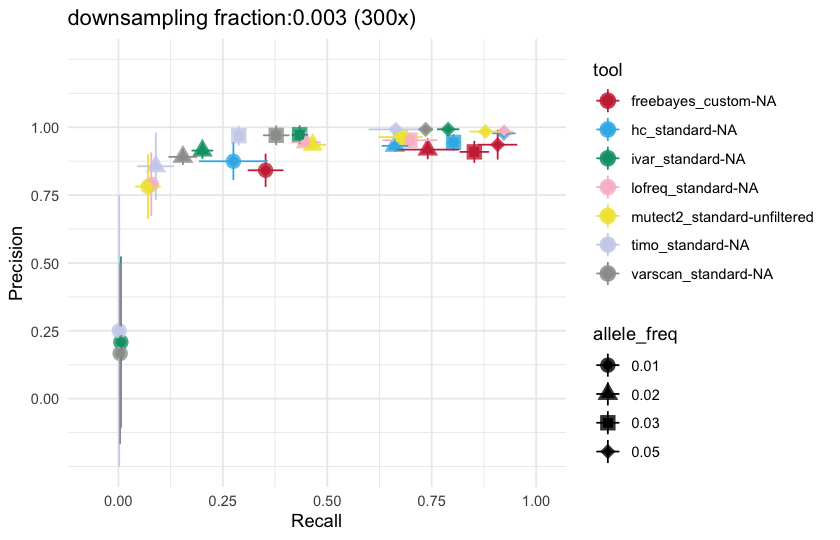

In [51]:
cov <- 300
af <- c(0.01,0.02,0.03,0.05)

plot7s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
              aes(x=mean_FDR, y=mean_TPR, shape=allele_freq, color = tool)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_TPR-sd_TPR, ymax=mean_TPR+sd_TPR)) +

    geom_pointrange(aes(xmin=mean_FDR-sd_FDR, xmax=mean_FDR+sd_FDR)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="False Discovery Rate",
                        breaks=seq(0,1,by=.25), 
                        limits=c(-0.05,1.05),expand=c(0,0)) +

    scale_y_continuous(name="True Positive Rate", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    ggtitle(glue("expected coverage:{cov}")) +

    theme_minimal()

plot8s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
             aes(x=mean_recall, y=mean_PPV, color = tool, shape=allele_freq)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_PPV-sd_PPV, ymax=mean_PPV+sd_PPV)) +

    geom_pointrange(aes(xmin=mean_recall-sd_recall, xmax=mean_recall+sd_recall)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="Recall",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.1,1.05),expand=c(0.01,0.01)) +

    scale_y_continuous(name="Precision", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.3,1.3),expand=c(0.01,0.01)) +


     scale_shape_manual(values = c(16, 17, 15, 18)) + 

    ggtitle(glue("downsampling fraction:{cov/100000} ({cov}x)")) +

    theme_minimal()

plot7s
plot8s
#options(repr.plot.width=7, repr.plot.height=4.5)
#ggarrange(plot8s, nrow = 1, ncol = 1)
#ggsave(plot7s, filename = glue("tpr.fpr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)
#ggsave(plot8s, filename = glue("pr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)

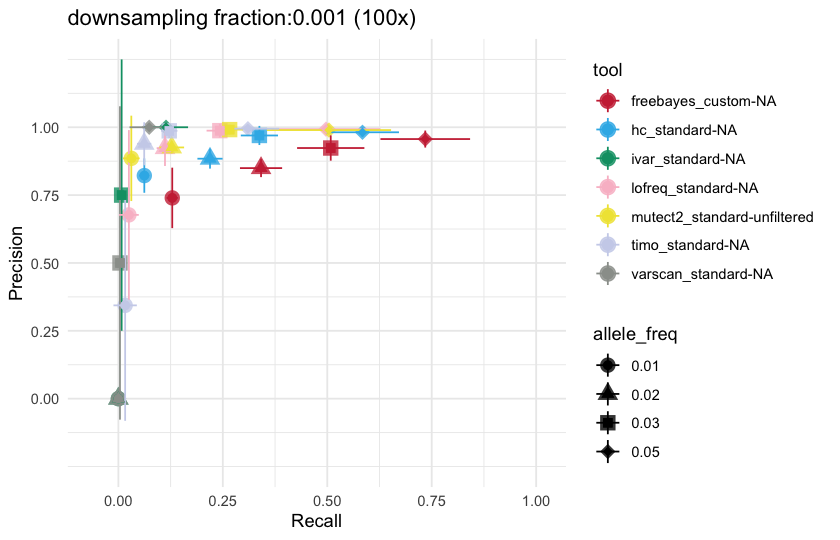

In [52]:
# kate adjustment of allison code 11.15.2022
cov <- 100
af <- c(0.01,0.02,0.03,0.05)


plot9s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
             aes(x=mean_recall, y=mean_PPV, color = tool, shape=allele_freq)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_PPV-sd_PPV, ymax=mean_PPV+sd_PPV)) +

    geom_pointrange(aes(xmin=mean_recall-sd_recall, xmax=mean_recall+sd_recall)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="Recall",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.1,1.05),expand=c(0.01,0.01)) +

    scale_y_continuous(name="Precision", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.3,1.3),expand=c(0.01,0.01)) +



    scale_shape_manual(values = c(16, 17, 15, 18)) + 

    ggtitle(glue("downsampling fraction:{cov/100000} ({cov}x)")) +

    theme_minimal()

plot9s
#options(repr.plot.width=7, repr.plot.height=4.5)
#ggarrange(plot9s, nrow = 1, ncol = 1)
#ggsave(plot7s, filename = glue("tpr.fpr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)
#ggsave(plot8s, filename = glue("pr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)

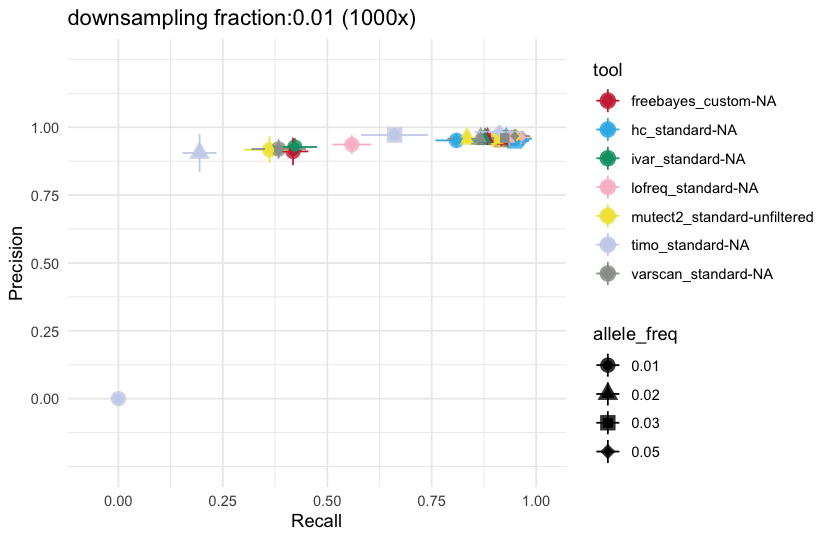

In [53]:
# kate adjustment of allison code 11.15.2022
cov <- 1000
af <- c(0.01,0.02,0.03,0.05)


plot10s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
             aes(x=mean_recall, y=mean_PPV, color = tool, shape=allele_freq)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_PPV-sd_PPV, ymax=mean_PPV+sd_PPV)) +

    geom_pointrange(aes(xmin=mean_recall-sd_recall, xmax=mean_recall+sd_recall)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="Recall",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.1,1.05),expand=c(0.01,0.01)) +

    scale_y_continuous(name="Precision", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.3,1.3),expand=c(0.01,0.01)) +



    scale_shape_manual(values = c(16, 17, 15, 18)) + 

    ggtitle(glue("downsampling fraction:{cov/100000} ({cov}x)")) +

    theme_minimal()

plot10s
#options(repr.plot.width=7, repr.plot.height=4.5)
#ggarrange(plot10s, nrow = 1, ncol = 1)
#ggsave(plot7s, filename = glue("tpr.fpr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)
#ggsave(plot8s, filename = glue("pr.standard.{cov}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)

In [ ]:
colnames(VV_setAF_grouped)

In [ ]:
VV_setAF_grouped %>% filter(tool %in% standard & coverage == 10000 & allele_freq == 0.02) %>% 
    select(tool, mean_recall, mean_PPV, mean_F1) %>%
    unique()

## Figure 1B: 
### updates 11.15.2022: 
- Adjusted the shape types 
- Increased the limits for the y- and x- axes to allow for the large errorbars to remain.
- changed the titles to include downsampling fraction and expected coverage
    

In [ ]:
options(repr.plot.width=21, repr.plot.height=4.5)
ggarrange(plot9s, plot6s, plot8s, nrow = 1, ncol = 3)

fig1b = ggarrange(plot9s, plot6s, plot8s, nrow = 1, ncol = 3)
print(fig1b)


ggsave(fig1b, filename = glue("Fig1B.updated.kj.pdf"),
       width = 21, height = 4.5, limitsize=FALSE, useDingbats =FALSE)


In [ ]:
options(repr.plot.width=14, repr.plot.height=9)
ggarrange(plot5s, plot6s, plot7s, plot8s, nrow = 2, ncol = 2)

In [26]:
# must make coverages factors in order to graph them
scores_full$coverage <- as.factor(scores_full$coverage)
VV_setAF_grouped$coverage <- as.factor(VV_setAF_grouped$coverage)

In [27]:
cov <- c(100,200,300,500,1000)
af <- 0.02

plot9s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
              aes(x=mean_FDR, y=mean_TPR, shape=coverage, color = tool)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_TPR-sd_TPR, ymax=mean_TPR+sd_TPR)) +

    geom_pointrange(aes(xmin=mean_FDR-sd_FDR, xmax=mean_FDR+sd_FDR)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="False Discovery Rate",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.05,1.05),expand=c(0,0)) +

    scale_y_continuous(name="True Positive Rate", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    ggtitle(glue("af:{af}")) +

    theme_minimal()

plot10s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
             aes(x=mean_recall, y=mean_PPV, color = tool, shape = coverage)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_PPV-sd_PPV, ymax=mean_PPV+sd_PPV)) +

    geom_pointrange(aes(xmin=mean_recall-sd_recall, xmax=mean_recall+sd_recall)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="Recall",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    scale_y_continuous(name="Precision", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    ggtitle(glue("af:{af}")) +

    theme_minimal()

#ggsave(plot9s, filename = glue("tpr.fpr.standard.{af}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)
#ggsave(plot10s, filename = glue("pr.standard.{af}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)

cov <- c(100,200,300,500,1000)
af <- 0.03

plot11s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% cov & allele_freq %in% af), 
              aes(x=mean_FDR, y=mean_TPR, shape=coverage, color = tool)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_TPR-sd_TPR, ymax=mean_TPR+sd_TPR)) +

    geom_pointrange(aes(xmin=mean_FDR-sd_FDR, xmax=mean_FDR+sd_FDR)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="False Discovery Rate",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.05,1.05),expand=c(0,0)) +

    scale_y_continuous(name="True Positive Rate", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    ggtitle(glue("af:{af}")) +

    theme_minimal()

plot12s = ggplot(subset(VV_setAF_grouped, tool %in% standard & coverage %in% c(100,200,300,500,1000) & allele_freq %in% c(0.03)), 
             aes(x=mean_recall, y=mean_PPV, color = tool, shape = coverage)) +

    geom_point(size=4, alpha=0.8) +

    geom_pointrange(aes(ymin=mean_PPV-sd_PPV, ymax=mean_PPV+sd_PPV)) +

    geom_pointrange(aes(xmin=mean_recall-sd_recall, xmax=mean_recall+sd_recall)) +

    scale_color_manual(values = tool_colors) +

    scale_x_continuous(name="Recall",
                       breaks=seq(0,1,by=.25),
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    scale_y_continuous(name="Precision", breaks=seq(0,1,by=0.25), 
                       limits=c(-0.05,1.05),expand=c(0.01,0.01)) +

    ggtitle(glue("af:{af}")) +

    theme_minimal()

#ggsave(plot11s, filename = glue("tpr.fpr.standard.{af}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)
#ggsave(plot12s, filename = glue("pr.standard.{af}.pdf"),
#    path=mva_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)

Warning message:
“Removed 3 rows containing missing values (geom_segment).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”


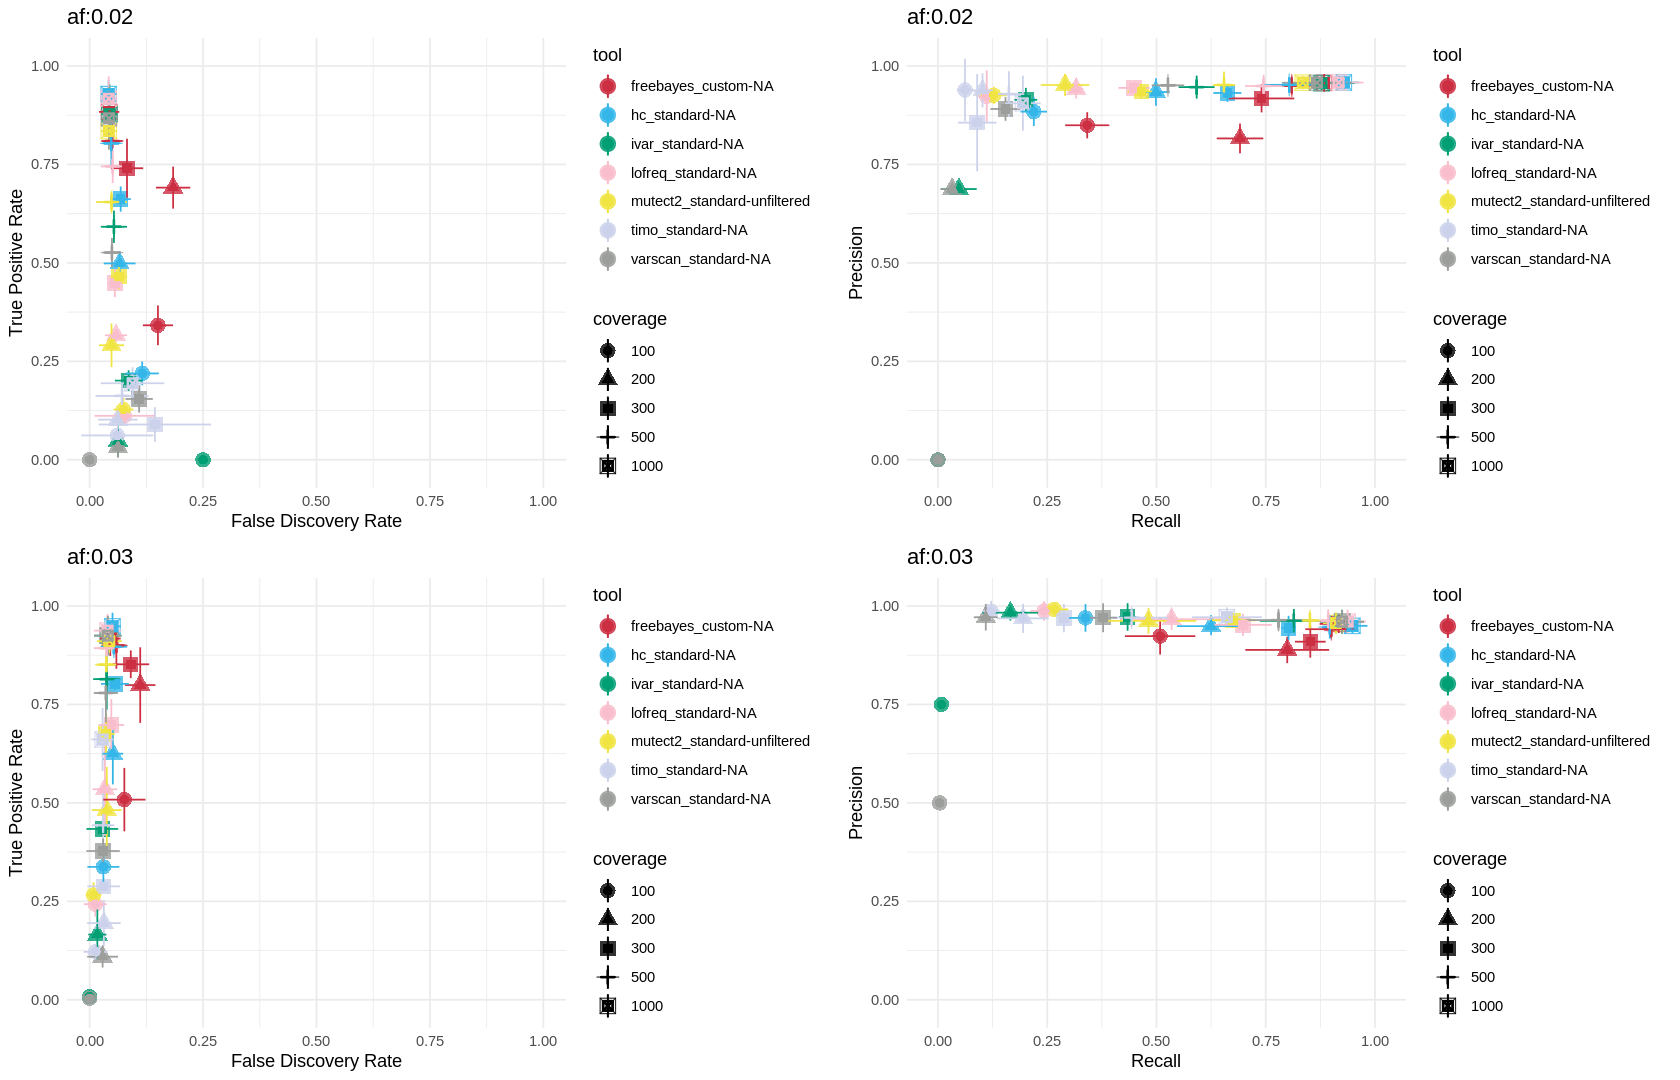

In [28]:
options(repr.plot.width=14, repr.plot.height=9)
ggarrange(plot9s, plot10s, plot11s, plot12s, nrow = 2, ncol = 2)

In [29]:
VV_randomAF$coverage <- as.factor(VV_randomAF$coverage)

In [30]:
VV_randomAF$set <- ifelse(VV_randomAF$tool %in% default, 'default',
                         ifelse(VV_randomAF$tool %in% standard, 'standard',
                               ifelse(VV_randomAF$tool %in% custom, 'custom', 'other')))

In [31]:
fb <- c('freebayes_standard-NA','freebayes_default-NA','freebayes_custom-NA')
hc <- c('hc_default-NA','hc_custom-NA','hc_standard-NA')
ivar <- c('ivar_default-NA','ivar_custom-NA','ivar_standard-NA')
lofreq <- c('lofreq_default-NA','lofreq_standard-NA','lofreq_custom-NA')
mutect <- c('mutect2_standard-unfiltered','mutect2_default-unfiltered','mutect2_custom-unfiltered') 
timo <- c('timo_custom-NA','timo_default-NA','timo_standard-NA')
varscan <- c('varscan_custom-1-NA','varscan_standard-NA','varscan_default-NA','varscan_custom-NA')

In [32]:
VV_randomAF <- VV_randomAF %>% distinct()

Warning message:
“Removed 6 rows containing missing values (geom_point).”


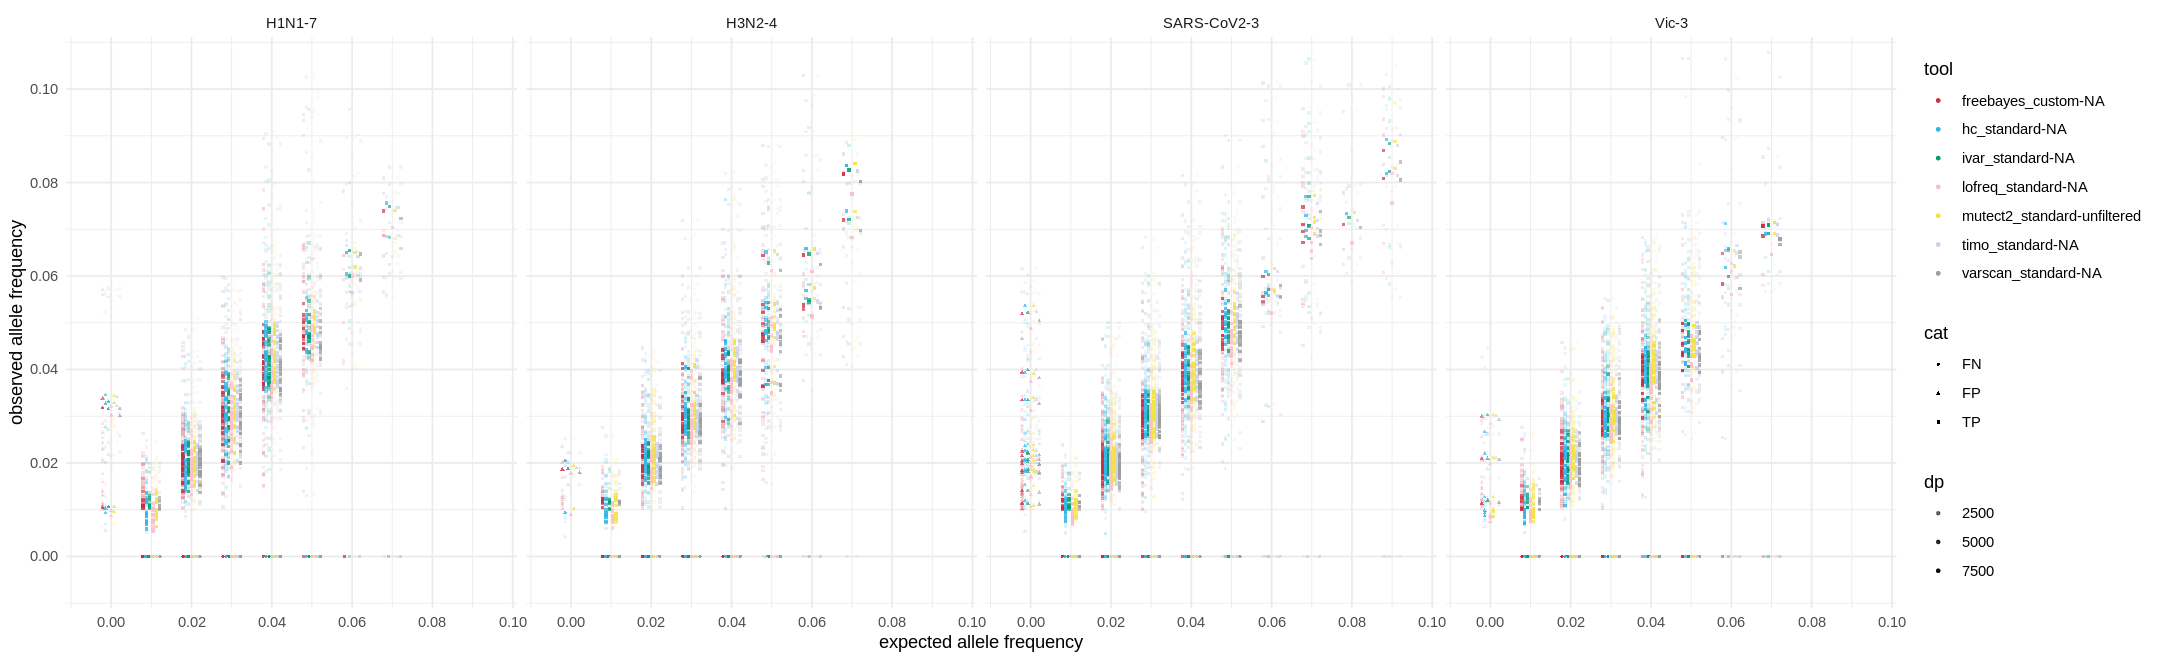

In [33]:
options(repr.plot.width=18, repr.plot.height=5.5)
plot13 <- VV_randomAF %>% filter(set == 'standard' & dp %in% c(100:10000)) %>%

    ggplot() +

    geom_point(data = VV_randomAF %>% subset(set == 'standard' & dp %in% c(100:10000) & !af_workflow == 0), 
                               aes(x = af_golden, y = af_workflow, shape = cat, color = tool, alpha = dp), 
               size = .6, position = position_dodge(width = 0.005)) +

    geom_point(data = VV_randomAF %>% subset(set == 'standard' & dp %in% c(100:10000) & af_workflow == 0), 
                               aes(x = af_golden, y = af_workflow, shape = cat, color = tool, alpha = dp), 
               size = .6, position = position_dodge(width = 0.005)) +

    #geom_point(size = 1, position = position_dodge(width = 0.01)) +

    theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30), 
          strip.text = element_text(size = 20)) +

    scale_x_continuous(name="expected allele frequency", 
                       breaks=seq(0,0.10,by=0.02), 
                       limits=c(-0.01,0.10),expand=c(0.001,0.001)) +

    scale_y_continuous(name="observed allele frequency", 
                       breaks=seq(0,0.11,by=0.02), 
                       limits=c(-0.01,0.11),expand=c(0.001,0.001)) +
    
    facet_grid(.~virus) +

    scale_color_manual(values = tool_colors) +

    theme_minimal()

print(plot13)

In [34]:
#ggsave(plot13, filename = "random.exp-vs-obs.pdf",
#    path=mva_folder, width = 18, height = 5.5, limitsize=FALSE, useDingbats =FALSE)

In [35]:
# filter the random allele frequency data for points at varying allele frequency and 
# count the number of FP,TP,FN is each category
#
# ie. how many of the SNVs above each allele frequency is timo calling correctly
#
high_df <- VV_randomAF %>%
    filter(set == 'standard' & af_golden > 0.05)
high_df$af_cat <- '>0.05'
high_df$total <- nrow(high_df)

mid_df <- VV_randomAF %>%
filter(set == 'standard' & af_golden == 0.05)
mid_df$af_cat <- '0.05'
mid_df$total <- nrow(mid_df)

lower_df <- VV_randomAF %>%
filter(set == 'standard' & af_golden == 0.03)
lower_df$af_cat <- '0.03'
lower_df$total <- nrow(lower_df)

low_df <- VV_randomAF %>%
filter(set == 'standard' & af_golden == 0.02)
low_df$af_cat <- '0.02'
low_df$total <- nrow(low_df)

full_df <- VV_randomAF %>%
filter(set == 'standard' & af_golden == 0.01)
full_df$af_cat <- '0.01' 
full_df$total <- nrow(full_df)

new_df <- rbind(high_df, mid_df)
new_df <- rbind(new_df, lower_df)
new_df <- rbind(new_df, low_df)
new_df <- rbind(new_df, full_df)

new_df <- new_df %>% filter(coverage %in% c(100,200,300,500,1000,10000))

In [36]:
# tally up the FN, FP and TP
counts2 <- new_df %>% group_by(tool, af_cat, cat) %>% tally()

counts2$af_cat <- factor(counts2$af_cat,levels = c(">0.05", "0.05", "0.03", "0.02","0.01"))

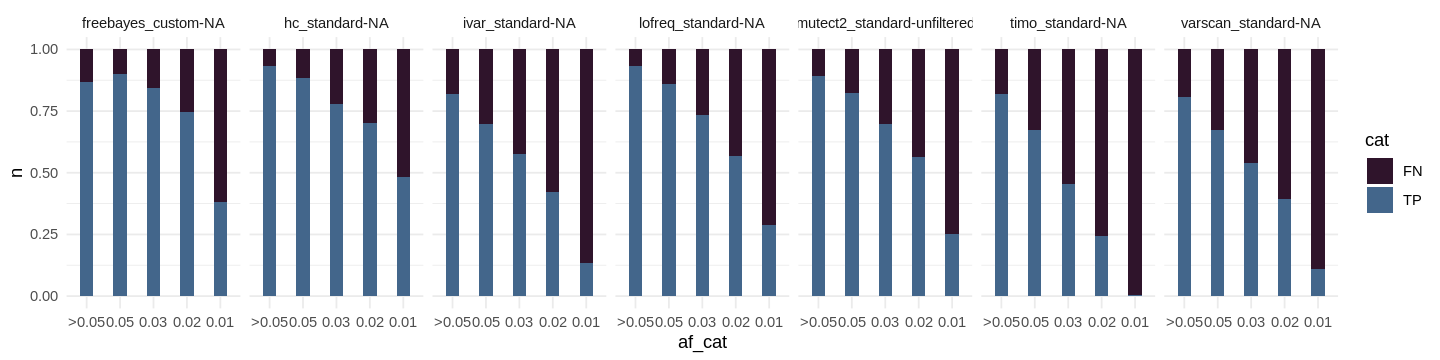

In [37]:
options(repr.plot.width=12, repr.plot.height=3)

plot14 <- ggplot(subset(counts2),
                        aes(x = af_cat, y = n))+

    geom_col(aes(fill = cat), width = 0.4, position = 'fill') +

    theme_minimal() + 
    
    facet_grid(.~ tool) +

    scale_fill_manual(values = cat_colors[c(1,3)])

print(plot14)

Where are the False Positives?
- What allele frequencies
- What read depths
- what down sampling fractions

In [38]:
VV_fptp <- VV_randomAF %>% filter(af_golden == 0)

# filter the random allele frequency data for points at varying allele frequency and 
# count the number of FP,TP,FN is each category
#
# ie. how many of the SNVs above each allele frequency is timo calling correctly
#
high_df <- VV_fptp %>%
    filter(set == 'standard' & af_workflow >= 0.05)
high_df$af_cat <- '>0.05'
high_df$total <- nrow(high_df)

mid_df <- VV_fptp %>%
filter(set == 'standard' & af_workflow < 0.05 & af_workflow >= 0.03)
mid_df$af_cat <- '0.03-0.05'
mid_df$total <- nrow(mid_df)

lower_df <- VV_fptp %>%
filter(set == 'standard' & af_workflow < 0.03 & af_workflow >= 0.02)
lower_df$af_cat <- '0.02-0.03'
lower_df$total <- nrow(lower_df)

low_df <- VV_fptp %>%
filter(set == 'standard' & af_workflow < 0.02 & af_workflow >= 0.01)
low_df$af_cat <- '0.01-0.02'
low_df$total <- nrow(low_df)

full_df <- VV_fptp %>%
filter(set == 'standard' & af_workflow < 0.01)
full_df$af_cat <- '<0.01' 
full_df$total <- nrow(full_df)

new_df <- rbind(high_df, mid_df)
new_df <- rbind(new_df, lower_df)
new_df <- rbind(new_df, low_df)
new_df <- rbind(new_df, full_df)

new_df <- new_df %>% filter(coverage %in% c(100,200,300,500,1000,10000))

In [39]:
# tally up the FN, FP and TP
counts2 <- new_df %>% group_by(tool, af_cat, cat) %>% tally()

counts2$af_cat <- factor(counts2$af_cat,levels = c(">0.05", "0.03-0.05", "0.02-0.03", "0.01-0.02","<0.01"))

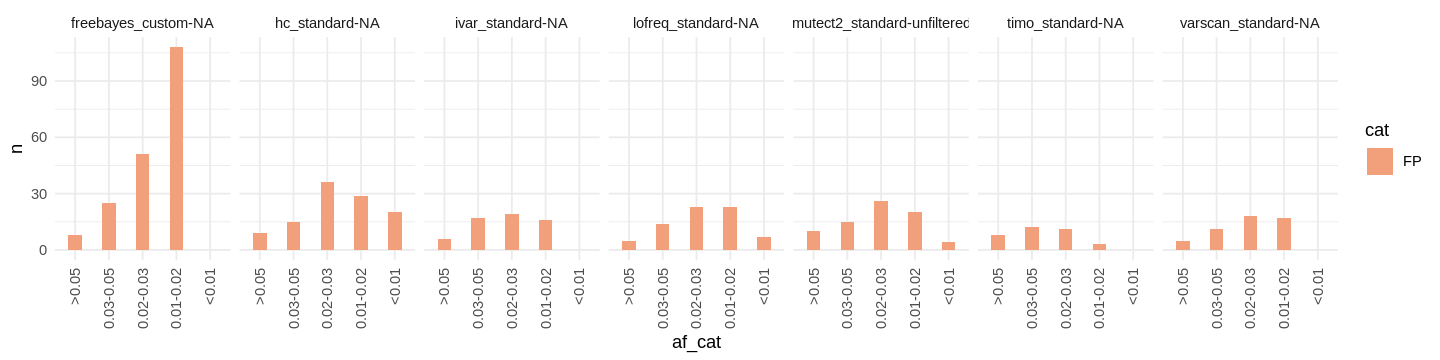

In [40]:
options(repr.plot.width=12, repr.plot.height=3)

plot15 <- ggplot(data = counts2 %>% subset(!tool == 'timo_standard-no-binom-check'),
                        aes(x = af_cat, y = n))+

    geom_col(aes(fill = cat), width = 0.4) +

    theme_minimal() + 

    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    
    facet_grid(.~ tool) +

    scale_fill_manual(values = cat_colors[c(2)])

print(plot15)

In [41]:
VV_fptp <- VV_randomAF %>% filter(af_golden == 0)

# filter the random allele frequency data for points at varying allele frequency and 
# count the number of FP,TP,FN is each category
#
# ie. how many of the SNVs above each allele frequency is timo calling correctly
#
high_df <- VV_fptp %>%
    filter(set == 'standard' & dp >= 1000)
high_df$dp_cat <- '>1000'
high_df$total <- nrow(high_df)

mid_df <- VV_fptp %>%
filter(set == 'standard' & dp %in% c(500:999))
mid_df$dp_cat <- '500-999'
mid_df$total <- nrow(mid_df)

lower_df <- VV_fptp %>%
filter(set == 'standard' & dp %in% c(300:499))
lower_df$dp_cat <- '300-499'
lower_df$total <- nrow(lower_df)

low_df <- VV_fptp %>%
filter(set == 'standard' & dp %in% c(200:299))
low_df$dp_cat <- '200-399'
low_df$total <- nrow(low_df)

full_df <- VV_fptp %>%
filter(set == 'standard' & dp < 200)
full_df$dp_cat <- '<200' 
full_df$total <- nrow(full_df)

new_df <- rbind(high_df, mid_df)
new_df <- rbind(new_df, lower_df)
new_df <- rbind(new_df, low_df)
new_df <- rbind(new_df, full_df)

#new_df <- new_df %>% filter(coverage %in% c(100,200,300,500,1000,10000))

In [42]:
# tally up the FN, FP and TP
counts2 <- new_df %>% group_by(tool, dp_cat, cat) %>% tally()

counts2$dp_cat <- factor(counts2$dp_cat,levels = c(">1000", "500-999", "300-499", "200-399","<200"))

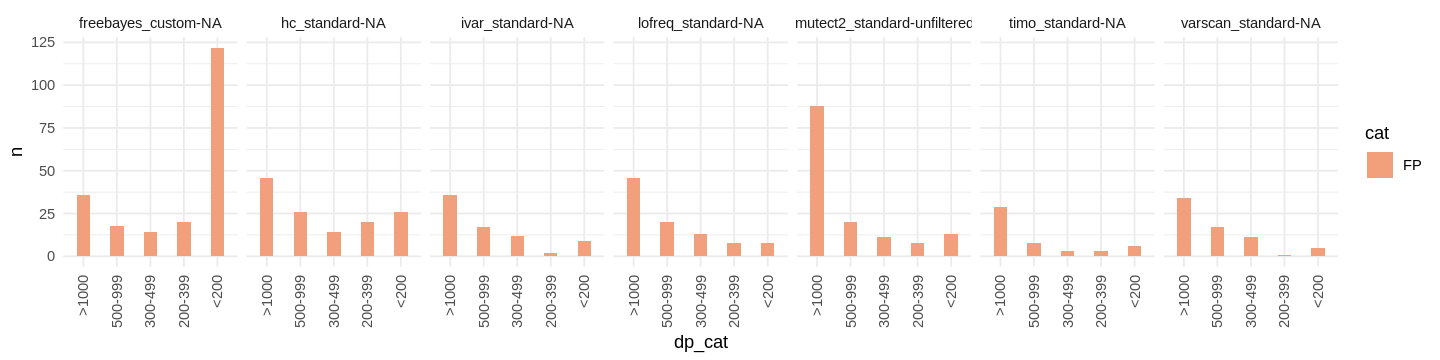

In [43]:
options(repr.plot.width=12, repr.plot.height=3)

plot16 <- ggplot(data = counts2 %>% subset(!tool == 'timo_standard-no-binom-check'),
                        aes(x = dp_cat, y = n))+

    geom_col(aes(fill = cat), width = 0.4) +

    theme_minimal() + 

    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    
    facet_grid(.~ tool) +

    scale_fill_manual(values = cat_colors[c(2)])

print(plot16)

In [44]:
VV_fptp <- VV_randomAF %>% filter(af_golden == 0)

# filter the random allele frequency data for points at varying allele frequency and 
# count the number of FP,TP,FN is each category
#
# ie. how many of the SNVs above each allele frequency is timo calling correctly
#
high_df <- VV_fptp %>%
    filter(set == 'standard' & coverage == 1000)
high_df$cov_cat <- '1000'
high_df$total <- nrow(high_df)

mid_df <- VV_fptp %>%
filter(set == 'standard' & coverage == 500)
mid_df$cov_cat <- '500'
mid_df$total <- nrow(mid_df)

lower_df <- VV_fptp %>%
filter(set == 'standard' & coverage == 300)
lower_df$cov_cat <- '300'
lower_df$total <- nrow(lower_df)

low_df <- VV_fptp %>%
filter(set == 'standard' & coverage == 200)
low_df$cov_cat <- '200'
low_df$total <- nrow(low_df)

full_df <- VV_fptp %>%
filter(set == 'standard' & coverage == 100)
full_df$cov_cat <- '100' 
full_df$total <- nrow(full_df)

new_df <- rbind(high_df, mid_df)
new_df <- rbind(new_df, lower_df)
new_df <- rbind(new_df, low_df)
new_df <- rbind(new_df, full_df)

#new_df <- new_df %>% filter(coverage %in% c(100,200,300,500,1000,10000))

In [45]:
# tally up the FN, FP and TP
counts2 <- new_df %>% group_by(tool, cov_cat, cat) %>% tally()

counts2$cov_cat <- factor(counts2$cov_cat,levels = c("1000", "500", "300", "200","100"))

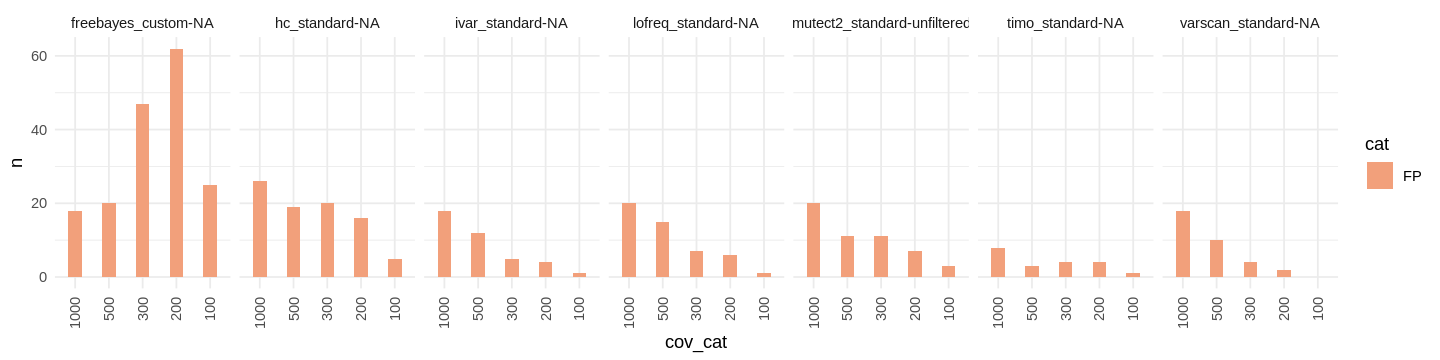

In [46]:
options(repr.plot.width=12, repr.plot.height=3)

plot17 <- ggplot(data = counts2 %>% subset(!tool == 'timo_standard-no-binom-check'),
                        aes(x = cov_cat, y = n))+

    geom_col(aes(fill = cat), width = 0.4) +

    theme_minimal() + 

    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    
    facet_grid(.~ tool) +

    scale_fill_manual(values = cat_colors[c(2)])

print(plot17)

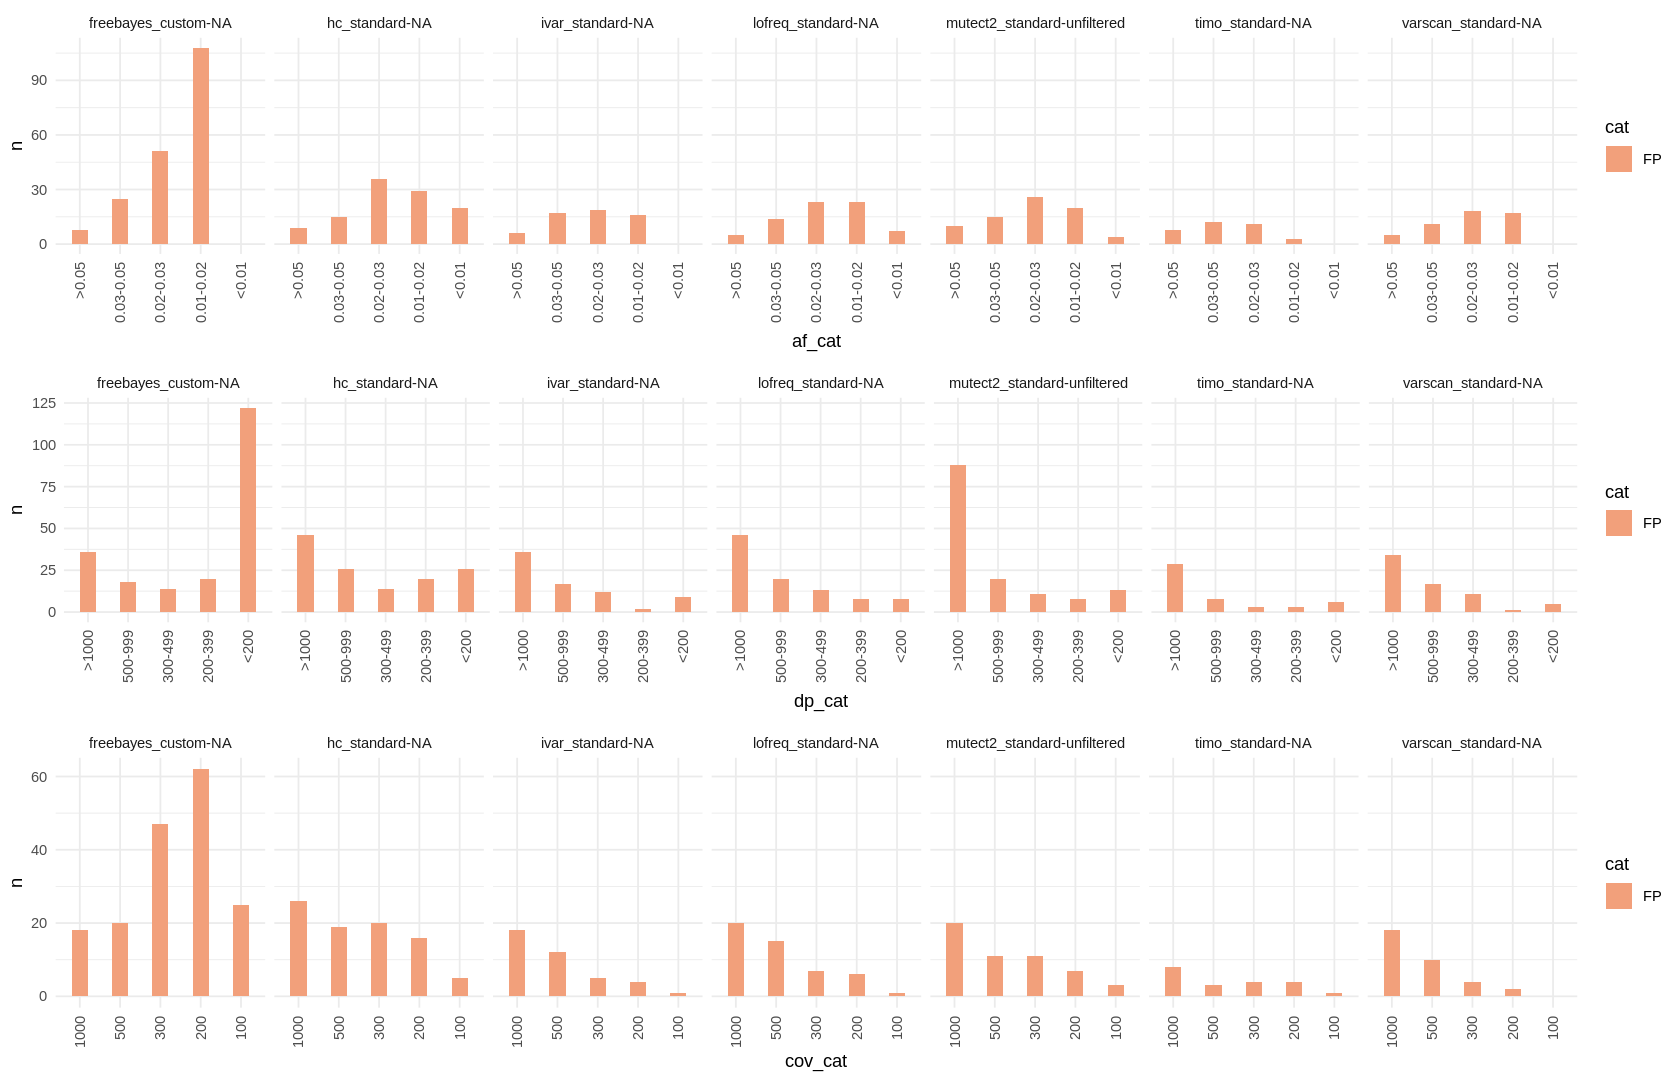

In [47]:
options(repr.plot.width=14, repr.plot.height=9)
ggarrange(plot15, plot16, plot17, nrow = 3, ncol = 1)